In [1]:
# Taken from https://github.com/ratschlab/repulsive_ensembles/data/toy_regression/regression1d_data.py

from abc import ABC, abstractmethod
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy.matlib as npm

class Dataset(ABC):
    """A general dataset template that can be used as a simple and consistent
    interface. Note, that this is an abstract class that should not be
    instantiated.

    The original implementation can be found `here <https://github.com/chrhenning/hypercl>`__.

    In order to write an interface for another dataset, you have to implement
    an inherited class. You must always call the constructor of this base class
    first when instantiating the implemented subclass.

    Note, the internals are stored in the private member ``_data``, that is
    described in the constructor.

    Attributes:
        classification: Whether the dataset is a classification or regression
            dataset.
        sequence: Whether the dataset contains sequences (samples have temporal
            structure).
            In case of a sequence dataset, the temporal structure can be
            decoded via the shape attributes of in- and outputs.
            Note, that all samples are internally zero-padded to the same
            length.
        num_classes: The number of classes for a classification task (``None``
            otherwise).
        is_one_hot: Whether output labels are one-hot encoded for a
            classification task (``None`` otherwise).
        in_shape: The original shape of an input sample. Note, that samples are
            encoded by this class as individual vectors (e.g., an MNIST sample
            is ancoded as 784 dimensional vector, but its original shape is:
            ``[28, 28, 1]``).
            A sequential sample is encoded by concatenating all timeframes.
            Hence, the number of timesteps can be decoded by dividing a single 
            sample vector by np.prod(in_shape).
        out_shape: The original shape of an output sample (see
            :attr:`in_shape`).
        num_train_samples: The number of training samples.
        num_test_samples: The number of test samples.
        num_val_samples: The number of validation samples.
        shuffle_test_samples: Whether the method :meth:`next_test_batch`
            returns test samples in random order at every epoch. Defaults to
            ``True``, i.e., samples have a random ordering every epoch.
        shuffle_val_samples: Same as :attr:`shuffle_test_samples` for samples
            from the validation set.
    """

    def __init__(self):
        # Internally, everything is stored in a certain structure, such that it
        # can easily be backuped (for instance via pickle).
        data = {}

        # Boolean: See attribute "classification".
        data.setdefault('classification', None)
        # Boolean: See attribute "sequence".
        data.setdefault('sequence', None)

        # Integer: See attribute "num_classes".
        data.setdefault('num_classes', None)
        # Integer: See attribute "is_one_hot".
        data.setdefault('is_one_hot', None)

        # A 2D numpy array, containing a sample input in each row (all samples
        # are encoded as single vectors.)
        data.setdefault('in_data', None)
        # A 2D numpy array, containing a sample output in each row (all samples
        # are encoded as single vectors.)
        data.setdefault('out_data', None)

        # List or numpy array: See attribute "in_shape".
        data.setdefault('in_shape', [])
        # List or numpy array: See attribute "in_shape".
        data.setdefault('out_shape', [])

        # List or numpy array: All row indices of "in_data" or "out_data", that
        # correspond to samples belonging to the training set.
        data.setdefault('train_inds', [])
        # List or numpy array: All row indices of "in_data" or "out_data", that
        # correspond to samples belonging to the test set.
        data.setdefault('test_inds', [])
        # List or numpy array: All row indices of "in_data" or "out_data", that
        # correspond to samples belonging to the validation set.
        data.setdefault('val_inds', None)

        self._data = data

        # These are other private attributes, that are not in the data dict
        # as there would be no reason to pickle them.
        self._batch_gen_train = None
        self._batch_gen_test = None
        self._batch_gen_val = None

        # We only need to fit the one-hot encoder for this dataset once.
        self._one_hot_encoder = None

        self._shuffle_test_samples = True
        self._shuffle_val_samples = True

    # TODO deprecate this attribute. Instead, distinguish between multi and
    # single label encoding.
    @property
    def classification(self):
        """Getter for read-only attribute :attr:`classification`."""
        return self._data['classification']

    @property
    def sequence(self):
        """Getter for read-only attribute :attr:`sequence`."""
        return self._data['sequence']

    @property
    def num_classes(self):
        """Getter for read-only attribute :attr:`num_classes`."""
        return self._data['num_classes']

    @property
    def is_one_hot(self):
        """Getter for read-only attribute :attr:`is_one_hot`."""
        return self._data['is_one_hot']

    @property
    def in_shape(self):
        """Getter for read-only attribute :attr:`in_shape`."""
        return self._data['in_shape']

    @property
    def out_shape(self):
        """Getter for read-only attribute :attr:`out_shape`."""
        return self._data['out_shape']

    @property
    def num_train_samples(self):
        """Getter for read-only attribute :attr:`num_train_samples`."""
        return np.size(self._data['train_inds'])

    @property
    def num_test_samples(self):
        """Getter for read-only attribute :attr:`num_test_samples`."""
        return np.size(self._data['test_inds'])

    @property
    def num_val_samples(self):
        """Getter for read-only attribute :attr:`num_val_samples`."""
        if self._data['val_inds'] is None:
            return 0
        return np.size(self._data['val_inds'])

    @property
    def shuffle_test_samples(self):
        """Getter attribute :attr:`shuffle_test_samples`."""
        return self._shuffle_test_samples

    @shuffle_test_samples.setter
    def shuffle_test_samples(self, value):
        """Setter for attribute :attr:`shuffle_test_samples`.

        Note, a call to this method will reset the current generator, such that
        the next call to the method :meth:`next_test_batch` results in starting
        a sweep through a new epoch (full batch).
        """
        self._shuffle_test_samples = value
        self._batch_gen_test = None

    @property
    def shuffle_val_samples(self):
        """Getter for attribute :attr:`shuffle_val_samples`."""
        return self._shuffle_val_samples

    @shuffle_val_samples.setter
    def shuffle_val_samples(self, value):
        """Setter for attribute :attr:`shuffle_val_samples`.

        See documentation of setter for attribute :attr:`shuffle_test_samples`.
        """
        self._shuffle_val_samples = value
        self._batch_gen_val = None

    def get_train_ids(self):
        """Get unique identifiers all training samples.

        Each sample in the dataset has a unique identifier (independent of the
        dataset split it is assigned to).

        Note:
            Sample identifiers do not correspond to the indices of samples
            within a dataset split (i.e., the returned identifiers of this
            method cannot be used as indices for the returned arrays of methods
            :meth:`get_train_inputs` and :meth:`get_train_outputs`)

        Returns:
            (numpy.ndarray): A 1D numpy array containing the unique identifiers
            for all training samples.
        """
        return self._data['train_inds']

    def get_test_ids(self):
        """Get unique identifiers all test samples.

        See documentation of method :meth:`get_train_ids` for details.

        Returns:
            (numpy.ndarray): A 1D numpy array.
        """
        return self._data['test_inds']

    def get_val_ids(self):
        """Get unique identifiers all validation samples.

        See documentation of method :meth:`get_train_ids` for details.

        Returns:
            (numpy.ndarray): A 1D numpy array. Returns ``None`` if no validation
            set exists.
        """
        if self._data['val_inds'] is None:
            return None
        return self._data['val_inds']

    def get_train_inputs(self):
        """Get the inputs of all training samples.
        
        Note, that each sample is encoded as a single vector. One may use the
        attribute :attr:`in_shape` to decode the actual shape of an input
        sample.
        
        Returns:
            (numpy.ndarray): A 2D numpy array, where each row encodes a training
            sample.
        """
        return self._data['in_data'][self._data['train_inds'], :]

    def get_test_inputs(self):
        """Get the inputs of all test samples.

        See documentation of method :meth:`get_train_inputs` for details.

        Returns:
            (numpy.ndarray): A 2D numpy array.
        """
        return self._data['in_data'][self._data['test_inds'], :]

    def get_val_inputs(self):
        """Get the inputs of all validation samples.

        See documentation of method :meth:`get_train_inputs` for details.

        Returns:
            (numpy.ndarray): A 2D numpy array. Returns ``None`` if no validation
            set exists.
        """
        if self._data['val_inds'] is None:
            return None
        return self._data['in_data'][self._data['val_inds'], :]

    def get_train_outputs(self, use_one_hot=None):
        """Get the outputs (targets) of all training samples.

        Note, that each sample is encoded as a single vector. One may use the
        attribute :attr:`out_shape` to decode the actual shape of an output
        sample. Keep in mind, that classification samples might be one-hot
        encoded.

        Args:
            use_one_hot (bool): For classification samples, the encoding of the
                returned samples can be either "one-hot" or "class index". This
                option is ignored for datasets other than classification sets.
                If ``None``, the dataset its default encoding is returned.

        Returns:
            (numpy.ndarray): A 2D numpy array, where each row encodes a training
            target.
        """
        out_data = self._data['out_data'][self._data['train_inds'], :]
        return self._get_outputs(out_data, use_one_hot)

    def get_test_outputs(self, use_one_hot=None):
        """Get the outputs (targets) of all test samples.

        See documentation of method :meth:`get_train_outputs` for details.

        Args:
            (....): See docstring of method :meth:`get_train_outputs`.

        Returns:
            (numpy.ndarray): A 2D numpy array.
        """
        out_data = self._data['out_data'][self._data['test_inds'], :]
        return self._get_outputs(out_data, use_one_hot)
    
    def get_val_outputs(self, use_one_hot=None):
        """Get the outputs (targets) of all validation samples.

        See documentation of method :meth:`get_train_outputs` for details.

        Args:
            (....): See docstring of method :meth:`get_train_outputs`.

        Returns:
            (numpy.ndarray): A 2D numpy array. Returns ``None`` if no validation
            set exists.
        """
        if self._data['val_inds'] is None:
            return None
        out_data = self._data['out_data'][self._data['val_inds'], :]
        return self._get_outputs(out_data, use_one_hot)

    def next_train_batch(self, batch_size, use_one_hot=None,
                         return_ids=False):
        """Return the next random training batch.

        If the behavior of this method should be reproducible, please define a
        numpy random seed.

        Args:
            (....): See docstring of method :meth:`get_train_outputs`.
            batch_size (int): The size of the returned batch.
            return_ids (bool): If ``True``, a third value will be returned
                that is a 1D numpy array containing sample identifiers.

                Note:
                    Those integer values are internal unique sample identifiers
                    and in general **do not** correspond to indices within the
                    corresponding dataset split (i.e., the training split in
                    this case).

        Returns:
            (list): List containing the following 2D numpy arrays:

            - **batch_inputs**: The inputs of the samples belonging to the
              batch.
            - **batch_outputs**: The outputs of the samples belonging to the
              batch.
            - **batch_ids** (optional): See option ``return_ident``.
        """
        if self._batch_gen_train is None:
            self.reset_batch_generator(train=True, test=False, val=False)

        batch_inds = np.fromiter(self._batch_gen_train, np.int,
                                 count=batch_size)
        ret = [self._data['in_data'][batch_inds, :],
               self._get_outputs(self._data['out_data'][batch_inds, :],
                                 use_one_hot)]

        if return_ids:
            return ret + [batch_inds]
        else:
            return ret

    def next_test_batch(self, batch_size, use_one_hot=None,
                        return_ids=False):
        """Return the next random test batch.

        See documentation of method :meth:`next_train_batch` for details.

        Args:
            (....): See docstring of method :meth:`next_train_batch`.

        Returns:
            (list): List containing the following 2D numpy arrays:

            - **batch_inputs**
            - **batch_outputs**
            - **batch_ids** (optional)
        """
        if self._batch_gen_test is None:
            self.reset_batch_generator(train=False, test=True, val=False)

        batch_inds = np.fromiter(self._batch_gen_test, np.int,
                                 count=batch_size)
        ret = [self._data['in_data'][batch_inds, :],
               self._get_outputs(self._data['out_data'][batch_inds, :],
                                 use_one_hot)]

        if return_ids:
            return ret + [batch_inds]
        else:
            return ret

    def next_val_batch(self, batch_size, use_one_hot=None,
                       return_ids=False):
        """Return the next random validation batch.

        See documentation of method :meth:`next_train_batch` for details.

        Args:
            (....): See docstring of method :meth:`next_train_batch`.

        Returns:
            (list): List containing the following 2D numpy arrays:

            - **batch_inputs**
            - **batch_outputs**
            - **batch_ids** (optional)

            Returns ``None`` if no validation set exists.
        """
        if self._data['val_inds'] is None:
            return None

        if self._batch_gen_val is None:
            self.reset_batch_generator(train=False, test=False, val=True)

        batch_inds = np.fromiter(self._batch_gen_val, np.int,
                                 count=batch_size)
        ret = [self._data['in_data'][batch_inds, :],
               self._get_outputs(self._data['out_data'][batch_inds, :],
                                 use_one_hot)]

        if return_ids:
            return ret + [batch_inds]
        else:
            return ret

    def reset_batch_generator(self, train=True, test=True, val=True):
        """The batch generation possesses a memory. Hence, the samples returned
        depend on how many samples already have been retrieved via the next-
        batch functions (e.g., :meth:`next_train_batch`). This method can be
        used to reset these generators.

        Args:
            train (bool): If ``True``, the generator for
                :meth:`next_train_batch` is reset.
            test (bool): If ``True``, the generator for :meth:`next_test_batch`
                is reset.
            val (bool): If ``True``, the generator for :meth:`next_val_batch`
                is reset, if a validation set exists.
        """
        if train:
            self._batch_gen_train = \
                Dataset._get_random_batch(self._data['train_inds'])

        if test:
            self._batch_gen_test = \
                Dataset._get_random_batch(self._data['test_inds'],
                                          self._shuffle_test_samples)

        if val and self._data['val_inds'] is not None:
            self._batch_gen_val = \
                Dataset._get_random_batch(self._data['val_inds'],
                                          self._shuffle_val_samples)

    def train_iterator(self, batch_size, return_remainder=True, **kwargs):
        """A generator to loop over the training set.

        This generator yields the return value of :meth:`next_train_batch`
        prepended with the current batch size.

        Example:
            .. code-block:: python

                for batch_size, x, y in data.train_iterator(32):
                    x_t = data.input_to_torch_tensor(x, device, mode='train')
                    y_t = data.output_to_torch_tensor(y, device, mode='train')

                    # ...

            .. code-block:: python

                for batch_size, x, y, ids in data.train_iterator(32, \\
                        return_ids=True):
                    x_t = data.input_to_torch_tensor(x, device, mode='train')
                    y_t = data.output_to_torch_tensor(y, device, mode='train')

                    # ...

        Note:
            This method will only temporarily modify the internal batch
            generator (see method :meth:`reset_batch_generator`) until the epoch
            is completed.

        Args:
            batch_size (int): The batch size used.

                Note:
                    If ``batch_size`` is not an integer divider of
                    :attr:`num_train_samples`, then the last yielded batch will
                    be smaller if ``return_remainder`` is ``True``.
            return_remainder (bool): The last batch might have to be smaller if
                ``batch_size`` is not an integer divider of
                :attr:`num_train_samples`. If this attribute is ``False``, this
                last part is not yielded and all batches have the same size.

                Note:
                    If ``return_remainder`` is se tto ``False``, then it may be
                    that not all training samples are yielded.
            **kwargs: Keyword arguments that are passed to method
                :meth:`next_train_batch`.

        Yields:
            (list): The same list that would be returned by method
            :meth:`next_train_batch` but additionally prepended with the batch
            size.
        """
        bgen_backup = self._batch_gen_train
        self._batch_gen_train = None

        num_samples = self.num_train_samples

        batch_gen = Dataset._split_iterator(batch_size, num_samples,
            self.next_train_batch, return_remainder, **kwargs)
        for batch in batch_gen:
            yield batch

        self._batch_gen_train = bgen_backup

    def test_iterator(self, batch_size, return_remainder=True, **kwargs):
        """A generator to loop over the test set.

        See documentation of method :meth:`train_iterator`.

        Args:
            (....): See docstring of method :meth:`train_iterator`.

        Yields:
            (list): The same list that would be returned by method
            :meth:`next_test_batch` but additionally prepended with the batch
            size.
        """
        bgen_backup = self._batch_gen_test
        self._batch_gen_test = None

        num_samples = self.num_test_samples

        batch_gen = Dataset._split_iterator(batch_size, num_samples,
            self.next_test_batch, return_remainder, **kwargs)
        for batch in batch_gen:
            yield batch

        self._batch_gen_test = bgen_backup

    def val_iterator(self, batch_size, return_remainder=True, **kwargs):
        """A generator to loop over the validation set.

        See documentation of method :meth:`train_iterator`.

        Args:
            (....): See docstring of method :meth:`train_iterator`.

        Yields:
            (list): The same list that would be returned by method
            :meth:`next_val_batch` but additionally prepended with the batch
            size.
        """
        if self._data['val_inds'] is None:
            raise ValueError('Dataset has no validation set.')

        bgen_backup = self._batch_gen_val
        self._batch_gen_val = None

        num_samples = self.num_val_samples

        batch_gen = Dataset._split_iterator(batch_size, num_samples,
            self.next_val_batch, return_remainder, **kwargs)
        for batch in batch_gen:
            yield batch

        self._batch_gen_val = bgen_backup

    def train_ids_to_indices(self, sample_ids):
        """Translate an array of training sample identifiers to training
        indices.

        This method translates unique training identifiers (see method
        :meth:`get_train_ids`) to actual training indices, that can be used
        to index the training set.

        Args:
            sample_ids (numpy.ndarray): 1D numpy array of unique sample IDs
                (e.g., those returned when using option ``return_ids`` of method
                :meth:`next_train_batch`).

        Returns:
            (numpy.ndarray): A 1D array of training indices that has the same
            length as ``sample_ids``.
        """
        return self._ids_to_indices(sample_ids, self._data['train_inds'])

    def test_ids_to_indices(self, sample_ids):
        """Translate an array of test sample identifiers to test indices.

        See documentation of method :meth:`train_ids_to_indices` for details.

        Args:
            (....): See docstring of method :meth:`train_ids_to_indices`.

        Returns:
            (numpy.ndarray): A 1D numpy array.
        """
        return self._ids_to_indices(sample_ids, self._data['test_inds'])

    def val_ids_to_indices(self, sample_ids):
        """Translate an array of validation sample identifiers to validation
        indices.

        See documentation of method :meth:`train_ids_to_indices` for details.

        Args:
            (....): See docstring of method :meth:`train_ids_to_indices`.

        Returns:
            (numpy.ndarray): A 1D numpy array.
        """
        if self._data['val_inds'] is None:
            raise ValueError('Dataset has no validation set.')
        return self._ids_to_indices(sample_ids, self._data['val_inds'])

    @abstractmethod
    def get_identifier(self):
        """Returns the name of the dataset.

        Returns:
            (str): The dataset its (unique) identifier.
        """
        pass

    def is_image_dataset(self):
        """Are input (resp. output) samples images?

        Note, for sequence datasets, this method just returns whether a single
        frame encodes an image.

        Returns:
            (tuple): Tuple containing two booleans:

            - **input_is_img**
            - **output_is_img**
        """
        # Note, if these comparisons do not hold, the method has to be
        # overwritten.
        in_img = np.size(self.in_shape) == 3 and self.in_shape[-1] in [1, 3, 4]
        out_img = np.size(self.out_shape) == 3 and \
            self.out_shape[-1] in [1, 3, 4]
        return (in_img, out_img)

    def tf_input_map(self, mode='inference'):
        """This method should be used by the map function of the Tensorflow
        Dataset interface (``tf.data.Dataset.map``). In the default case, this
        is just an identity map, as the data is already in memory.

        There might be cases, in which the full dataset is too large for the
        working memory, and therefore the data currently needed by Tensorflow
        has to be loaded from disk. This function should be used as an
        interface for this process.

        Args:
            mode (str): Is the data needed for training or inference? This
                distinction is important, as it might change the way the data is
                processed (e.g., special random data augmentation might apply
                during training but not during inference. The parameter is a
                string with the valid values being ``train`` and ``inference``.

        Returns:
            (function): A function handle, that maps the given input tensor to
            the preprocessed input tensor.
        """
        return lambda x : x

    def tf_output_map(self, mode='inference'):
        """Similar to method :meth:`tf_input_map`, just for dataset outputs.

        Note, in this default implementation, it is also just an identity map.
        
        Args:
            (....): See docstring of method :meth:`tf_input_map`.

        Returns:
            (function): A function handle.
        """
        return lambda x : x

    def input_to_torch_tensor(self, x, device, mode='inference',
                              force_no_preprocessing=False, sample_ids=None):
        """This method can be used to map the internal numpy arrays to PyTorch
        tensors.

        Note, subclasses might overwrite this method and add data preprocessing/
        augmentation.

        Args:
            x (numpy.ndarray): A 2D numpy array, containing inputs as provided
                by this dataset.
            device (torch.device or int): The PyTorch device onto which the
                input should be mapped.
            mode (str): See docstring of method :meth:`tf_input_map`.
                  Valid values are: ``train`` and ``inference``.
            force_no_preprocessing (bool): In case preprocessing is applied to
                the inputs (e.g., normalization or random flips/crops), this
                option can be used to prohibit any kind of manipulation. Hence,
                the inputs are transformed into PyTorch tensors on an "as is"
                basis.
            sample_ids (numpy.ndarray): See method
                :meth:`train_ids_to_indices`. Instantiation of this class might
                make use of this information, for instance in order to reduce
                the amount of zero padding within a mini-batch.

        Returns:
            (torch.Tensor): The given input ``x`` as PyTorch tensor.
        """
        # Note, this import is only needed for the functions:
        # input_to_torch_tensor() and output_to_torch_tensor()
        from  torch import from_numpy
        return from_numpy(x).float().to(device)

    def output_to_torch_tensor(self, y, device, mode='inference',
                               force_no_preprocessing=False, sample_ids=None):
        """Similar to method :meth:`input_to_torch_tensor`, just for dataset
        outputs.

        Note, in this default implementation, it is also does not perform any
        data preprocessing.

        Args:
            (....): See docstring of method :meth:`input_to_torch_tensor`.

        Returns:
            (torch.Tensor): The given output ``y`` as PyTorch tensor.
        """
        from  torch import from_numpy
        return from_numpy(y).float().to(device)

    def plot_samples(self, title, inputs, outputs=None, predictions=None,
                     num_samples_per_row=4, show=True, filename=None,
                     interactive=False, figsize=(10, 6), **kwargs):
        """Plot samples belonging to this dataset. Each sample will be plotted
        in its own subplot.

        Args:
            title (str): The title of the whole figure.
            inputs (numpy.ndarray): A 2D numpy array, where each row is an input
                sample.
            outputs (numpy.ndarray, optional): A 2D numpy array of actual
                dataset targets.
            predictions (numpy.ndarray, optional): A 2D numpy array of predicted
                output samples (i.e., output predicted by a neural network).
            num_samples_per_row (int): Maximum number of samples plotted
                per row in the generated figure.
            show (bool): Whether the plot should be shown.
            filename (str, optional): If provided, the figure will be stored
                under this filename.
            interactive (bool): Turn on interactive mode. We mainly
                use this option to ensure that the program will run in
                background while figure is displayed. The figure will be
                displayed until another one is displayed, the user closes it or
                the program has terminated. If this option is deactivated, the
                program will freeze until the user closes the figure.
                Note, if using the iPython inline backend, this option has no
                effect.
            figsize (tuple): A tuple, determining the size of the
                figure in inches.
            **kwargs (optional): Optional keyword arguments that can be dataset
                dependent.
        """
        # Determine the configs for the grid of this figure.
        pc = self._plot_config(inputs, outputs=outputs,
                               predictions=predictions)

        # Reverse one-hot encoding.
        if self.classification:
            num_time_steps = 1
            if self.sequence:
                num_time_steps = self._data['out_data'].shape[1] // \
                                 np.prod(self.out_shape)

            one_hot_size = num_time_steps * self.num_classes
            if outputs is not None and outputs.shape[1] == one_hot_size:
                outputs = self._to_one_hot(outputs, True)

            # Note, we don't reverse the encoding for predictions, as this
            # might be important for the subsequent plotting method.

        num_plots = inputs.shape[0]
        num_cols = int(min(num_plots, num_samples_per_row))
        num_rows = int(np.ceil(num_plots / num_samples_per_row))

        fig = plt.figure(figsize=figsize)
        outer_grid = gridspec.GridSpec(num_rows, num_cols,
                                       wspace=pc['outer_wspace'],
                                       hspace=pc['outer_hspace'])

        plt.suptitle(title, size=20)
        if interactive:
            plt.ion()

        outs = None
        preds = None

        for i in range(num_plots):
            inner_grid = gridspec.GridSpecFromSubplotSpec(pc['num_inner_rows'],
                pc['num_inner_cols'], subplot_spec=outer_grid[i],
                wspace=pc['inner_wspace'], hspace=pc['inner_hspace'])

            if outputs is not None:
                outs = outputs[i, np.newaxis]
            if predictions is not None:
                preds = predictions[i, np.newaxis]

            self._plot_sample(fig, inner_grid, pc['num_inner_plots'], i,
                              inputs[i, np.newaxis], outputs=outs, 
                              predictions=preds, **kwargs)

        if show:
            plt.show()

        if filename is not None:
            plt.savefig(filename, bbox_inches='tight')

    @abstractmethod
    def _plot_sample(self, fig, inner_grid, num_inner_plots, ind, inputs,
                     outputs=None, predictions=None, **kwargs):
        """Add a custom sample plot to the given Axes object.

        Note, this method is called by the :meth:`plot_samples` method.

        Note, that the number of inner subplots is configured via the method:
        :meth:`_plot_config`.

        Args:
            fig: An instance of class matplotlib.figure.Figure, that will
                contains the given Axes object.
            inner_grid: An object of the class
                matplotlib.gridspec.GridSpecFromSubplotSpec. It can be used to
                access the subplots of a single sample via
                    ax = plt.Subplot(fig, inner_grid[i])
                where i is a number between 0 and num_inner_plots-1.
                The retrieved axes has to be added to the figure via:
                    fig.add_subplot(ax)
            num_inner_plots: The number inner subplots.
            ind: The index of the "outer" subplot.
            inputs: A 2D numpy array, containing a single sample (1 row).
            outputs (optional): A 2D numpy array, containing a single sample 
                (1 row). If this is a classification dataset, then samples are
                given as single labels (not one-hot encoded, irrespective of
                the attribute is_one_hot).
            predictions (optional): A 2D numpy array, containing a single 
                sample (1 row).
            **kwargs: Optional keyword arguments that can be passed to the
                underlying plot function.
        """
        pass

    def _plot_config(self, inputs, outputs=None, predictions=None):
        """Defines properties, used by the method :meth:`plot_samples`.

        This method can be overwritten, if these configs need to be different
        for a certain dataset.

        Args:
            The given arguments are the same as the same-named arguments of
            the method :meth:`plot_samples`. They might be used by subclass
            implementations to determine the configs.

        Returns:
            (dict): A dictionary with the plot configs.
        """
        plot_configs = dict()
        plot_configs['outer_wspace'] = 0.4
        plot_configs['outer_hspace'] = 0.4
        plot_configs['inner_hspace'] = 0.2
        plot_configs['inner_wspace'] = 0.2
        plot_configs['num_inner_rows'] = 1
        plot_configs['num_inner_cols'] = 1
        plot_configs['num_inner_plots'] = 1

        return plot_configs

    def _get_outputs(self, data, use_one_hot=None):
        """A helper method for the output data getter methods. It will ensure,
        that the output encoding is correct.

        Args:
            data: The data to be returned (maybe after a change of encoding).
            use_one_hot: How data should be encoded.

        Returns:
            See documentation of method :meth:`get_train_outputs`.
        """
        if self.classification:
            if use_one_hot is None:
                use_one_hot = self.is_one_hot

            if use_one_hot != self.is_one_hot:
                # Toggle current encoding.
                if self.is_one_hot:
                    return self._to_one_hot(data, reverse=True)
                else:
                    return self._to_one_hot(data)

        return data

    def _to_one_hot(self, labels, reverse=False):
        """ Transform a list of labels into a 1-hot encoding.

        Args:
            labels: A list of class labels.
            reverse: If ``True``, then one-hot encoded samples are transformed
                back to categorical labels.

        Returns:
            The 1-hot encoded labels.
        """
        if not self.classification:
            raise RuntimeError('This method can only be called for ' +
                                   'classification datasets.')

        # Initialize encoder.
        if self._one_hot_encoder is None:
            self._one_hot_encoder = OneHotEncoder( \
                categories=[range(self.num_classes)])
            self._one_hot_encoder.fit(npm.repmat(
                    np.arange(self.num_classes), 1, 1).T)

        if reverse:
            # Unfortunately, there is no inverse function in the OneHotEncoder
            # class. Therefore, we take the one-hot-encoded "labels" samples
            # and take the indices of all 1 entries. Note, that these indices
            # are returned as tuples, where the second column contains the
            # original column indices. These column indices from "labels"
            # mudolo the number of classes results in the original labels.
            return np.reshape(np.argwhere(labels)[:,1] % self.num_classes, 
                              (labels.shape[0], -1))
        else:
            if self.sequence:
                assert len(self.out_shape) == 1
                num_time_steps = labels.shape[1] # // 1
                n_samples, _ = labels.shape
                labels = labels.reshape(n_samples * num_time_steps, 1)
                labels = self._one_hot_encoder.transform(labels).toarray()
                labels = labels.reshape(n_samples,
                                        num_time_steps * self.num_classes)

                return labels
            else:
                return self._one_hot_encoder.transform(labels).toarray()

    @staticmethod
    def _get_random_batch(indices, shuffle=True):
        """Returns a generator that yields sample indices from the randomly
        shuffled given dataset (prescribed by those indices). After a whole
        sweep through the array is completed, the indices are shuffled again.

        The implementation is inspired by another method I've implemented:
            The method "random_shuffle_loop": from https://git.io/fNDZJ

        Note, to get reproducable behavior, set a numpy random seed.

        Args:
            indices: A 1D numpy array of indices.
            shuffle (default: True): Whether the indices are shuffled every
                                     epoch. If this option is deactivated, the
                                     indices are simply processed in the
                                     given order every round.

        Returns:
            A generator object, that yields indices from the given array.

        Example Usage:
        >>> import iterlist
        >>> batch_size = 32
        >>> batch_generator = Dataset._get_random_batch(indices)
        >>> batch_inds = np.array( \
        ...     list(itertools.islice(batch_generator, batch_size)))
        
        Runtime Benchmark: What is a fast way to call the method?
        Note, that np.fromiter only works since indices is a 1D array.
        >>> import timeit
        >>> setup = '''
        ... import numpy as np
        ... import itertools
        ... from dataset import Dataset
        ... 
        ... indices = np.random.randint(0, high=100, size=100)
        ... 
        ... batch_size = 32
        ... batch_generator = Dataset._get_random_batch(indices)
        ... '''
        >>> print(timeit.timeit(
        ...     stmt="batch_inds = np.array(list(itertools.islice(" +
        ...          "batch_generator, batch_size)))",
        ...     setup=setup, number=100000))
        1.1637690339994151
        >>> print(timeit.timeit(
        ...     stmt="batch_inds = np.stack([next(batch_generator) " +
        ...          "for i in range(batch_size)])",
        ...     setup=setup, number=100000))
        6.16505571999005
        >>> print(timeit.timeit(
        ...     stmt="batch_inds = np.fromiter(itertools.islice(" +
        ...         batch_generator, batch_size), int)",
        ...     setup=setup, number=100000))
        0.9456974960048683
        >>> print(timeit.timeit(
        ...     stmt="batch_inds = np.fromiter(batch_generator, int, " +
        ...                                    count=batch_size)",
        ...     setup=setup, number=100000))
        0.871306327986531
        """
        num_samples = np.shape(indices)[0]
        arr_inds = np.arange(num_samples)
        i = num_samples
        while True:
            if i == num_samples:
                i = 0
                if shuffle:
                    np.random.shuffle(arr_inds)
            yield indices[arr_inds[i]]
            i += 1

    def _ids_to_indices(self, sample_ids, split_indices):
        """Translate IDs to indices.

        Helper method for methods like :meth:`train_ids_to_indices`.

        Args:
            (....): See docstring of method :meth:`train_ids_to_indices`.
            split_indices (numpy.ndarray): 1D array of indices belonging to a
                certain dataset split.

        Returns:
            (numpy.ndarray): See docstring of method
            :meth:`train_ids_to_indices`.
        """
        if not np.all(np.isin(sample_ids, split_indices)):
            raise ValueError('Some of the given IDs are not in the dataset ' +
                             'split.')

        sorted_inds = np.argsort(split_indices)
        return np.searchsorted(split_indices[sorted_inds], sample_ids)

    @staticmethod
    def _split_iterator(batch_size, num_samples, next_batch_fun,
                        return_remainder, **kwargs):
        """Helper method for methods like :meth:`train_iterator`.

        Args:
            (....): See docstring of method :meth:`train_iterator`.
            num_samples (int): Total number of samples in dataset split.
            next_batch_fun (func): Function handle to obtain next batch.

        Yields:
            (....): See docstring of method :meth:`train_iterator`.
        """
        curr_bs = batch_size
        n_processed = 0

        while n_processed < num_samples:
            if n_processed + curr_bs > num_samples:
                curr_bs = num_samples - n_processed
            n_processed += curr_bs

            if batch_size != curr_bs and not return_remainder:
                break

            batch = next_batch_fun(curr_bs, **kwargs)
            yield [curr_bs] + batch

    def __str__(self):
        """Print major characteristics of the current dataset."""
        return 'Dataset "%s" with %d training, %d test and %d validation ' \
            % (self.get_identifier(), self.num_train_samples,
               self.num_test_samples, self.num_val_samples) + 'samples.'

In [3]:
# Taken from https://github.com/ratschlab/repulsive_ensembles/data/toy_regression/regression1d_data.py

import numpy as np
import matplotlib.pyplot as plt

class ToyRegression:
    def __init__(self, train_inter, num_train, test_inter, num_test, val_inter, num_val, map_function, std, rseed=42, blob=None):
        np.random.seed(rseed)
        self.train_x = np.random.uniform(train_inter[0], train_inter[1], num_train)
        self.train_y = map_function(self.train_x) + np.random.normal(0, std, num_train)

        # Filter out training data in the range [3, 4.5]
        mask = (self.train_x < 3) | (self.train_x > 4.5)
        self.train_x = self.train_x[mask]
        self.train_y = self.train_y[mask]

        self.test_x = np.linspace(test_inter[0], test_inter[1], num_test)
        self.test_y = map_function(self.test_x) + np.random.normal(0, std, num_test)
        self.true_test_y = map_function(self.test_x)  # True test values without Gaussian noise
        
        self.val_x = np.random.uniform(val_inter[0], val_inter[1], num_val)
        self.val_y = map_function(self.val_x) + np.random.normal(0, std, num_val)
        
        if blob is not None:
            for b in blob:
                points = np.random.uniform(b[0], b[1], num_train // len(blob))
                points = points[(points < 3) | (points > 4)]  # Filter out points in the range [3, 4.5]
                self.train_x = np.concatenate([self.train_x, points])
                self.train_y = np.concatenate([self.train_y, map_function(points) + np.random.normal(0, std, len(points))])

    def plot(self):
        plt.figure(figsize=(12, 6))
        plt.scatter(self.train_x, self.train_y, color='blue', label='Train Data')
        plt.scatter(self.val_x, self.val_y, color='green', label='Validation Data')
        plt.scatter(self.test_x, self.test_y, color='red', label='Test Data')
        plt.legend()
        plt.show()

def generate_1d_dataset(show_plots=True, task_set=0, data_random_seed=42):
    """Generate a set of tasks for 1D regression.

    Args:
        show_plots: Visualize the generated datasets.
        data_random_seed: Random seed that should be applied to the
            synthetic data generation.
        task_set: int for the regression task 

    Returns:
        data_handlers: A data handler
    """

    map_funcs = [
        lambda x: (x) ** 3.,
        lambda x: (3. * x),
        lambda x: 2. * np.power(x, 2) - 1,
        lambda x: np.power(x - 3., 3),
        lambda x: x * np.sin(x),
        lambda x: x * (1 + np.sin(x))
    ]
    x_domains = [[-3.5, 3.5], [-2, 2], [-1, 1], [2, 4], [2, 6], [3, 12]]
    test_domains = [[-5.0, 5.0], [-3, 3], [-2.5, 2.5], [0.5, 4.1], [0, 7], [2, 13]]
    std = [3, 0.05, 0.05, 0.05, 0.25, 0.6]
    num_train = 150
    num_test = 200  # Increased number of test points for smoother line
    blob = [None, None, None, None, [[1.5, 2.5], [4.5, 6.0]], [[4.5, 5], [7.5, 8.5], [10, 11]]]

    data = ToyRegression(
        train_inter=x_domains[task_set],
        num_train=num_train,
        test_inter=test_domains[task_set],
        num_test=num_test,
        val_inter=x_domains[task_set],
        num_val=100,
        map_function=map_funcs[task_set],
        std=std[task_set],
        rseed=data_random_seed
    )

    if show_plots:
        data.plot()
        
    return data

# Example usage
data = generate_1d_dataset(show_plots=False, task_set=4, data_random_seed=42)


x_train (73, 1)
x_val (19, 1)
test_x (200, 1)
Layer sizes: [1, 50, 50, 1]


100%|██████████| 1/1 [00:00<00:00, 1018.28it/s]


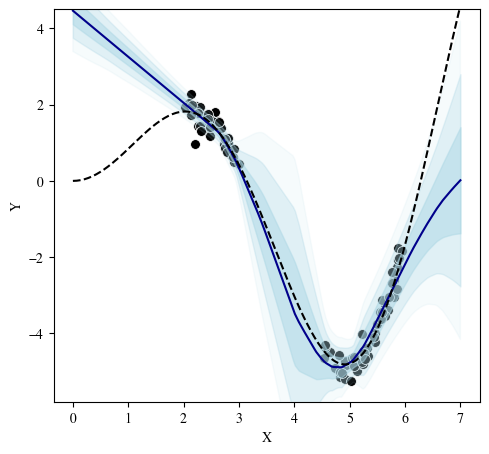

In [20]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import contextlib
from tueplots import figsizes, cycler, fonts
from tueplots.constants.color import palettes


from hydra import initialize, compose
from omegaconf import OmegaConf

from train.train import train


from models.mlp import initialise_mlp_models  # Ensure this is correctly imported

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
# Initialize Hydra and compose the configuration
#initialize(version_base="1.3.2", config_path="conf", job_name="test_app")
cfg = compose(config_name="config")
#print(OmegaConf.to_yaml(cfg))
cfg.experiment.batch_size=8
cfg.experiment.lr=3e-2
cfg.experiment.num_epochs=200
cfg.task.dataset='mnist'
cfg.experiment.wandb_logging=False
cfg.experiment.method='Ensemble'

# Generate data using the previously defined function
data = generate_1d_dataset(show_plots=False, task_set=4, data_random_seed=42)
train_x, train_y = data.train_x, data.train_y
test_x, test_y = data.test_x, data.test_y

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# Reshape the data to 2D arrays
x_train = x_train.reshape(-1, 1)
x_val = x_val.reshape(-1, 1)
test_x = test_x.reshape(-1, 1)
y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)
test_y = test_y.reshape(-1,1)

# Normalize the data
#scaler = StandardScaler()
#x_train = scaler.fit_transform(x_train)
#x_val = scaler.transform(x_val)
#test_x = scaler.transform(test_x)

print('x_train', x_train.shape)
print('x_val', x_val.shape)
print('test_x', test_x.shape)

# Create datasets
train_dataset = CustomDataset(x_train, y_train)
val_dataset = CustomDataset(x_val, y_val)
test_dataset = CustomDataset(test_x, test_y)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize MLP models
input_dim = x_train.shape[1]
output_dim = 1  # Assuming the target variable is a single dimension
num_models = cfg.experiment.n_particles  # Number of models in the ensemble




modellist = initialise_mlp_models(input_dim, output_dim, cfg)


# Train the models
#loss = train(modellist, cfg['experiment']['lr'], cfg['experiment']['num_epochs'], train_dataloader, val_dataloader, device, cfg)
# Train the models while suppressing print statements
with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    loss = train(modellist, cfg['experiment']['lr'], cfg['experiment']['num_epochs'], train_dataloader, val_dataloader, device, cfg)


# Function to generate predictions
def predict(models, dataloader, device):
    models = [model.to(device) for model in models]
    for model in models:
        model.eval()
    mean_predictions = []
    std_predictions = []
    with torch.no_grad():
        for x_batch, _ in dataloader:
            x_batch = x_batch.to(device)
            batch_preds = [model(x_batch).cpu().numpy() for model in models]
            batch_preds = np.stack(batch_preds, axis=0)
            batch_mean = np.mean(batch_preds, axis=0)
            batch_std = np.std(batch_preds, axis=0)
            mean_predictions.extend(batch_mean)
            std_predictions.extend(batch_std)
    return np.array(mean_predictions), np.array(std_predictions)

# Generate predictions on the test set
mean_predictions, std_predictions = predict(modellist, test_dataloader, device)

# Flatten arrays for plotting
train_x = train_x.flatten()
train_y = train_y.flatten()
test_x = test_x.flatten()
test_y = test_y.flatten()
mean_predictions = mean_predictions.flatten()
std_predictions = std_predictions.flatten()

sorted_indices = np.argsort(test_x)
test_x_sorted = test_x[sorted_indices]
mean_predictions_sorted = mean_predictions[sorted_indices]
std_predictions_sorted = std_predictions[sorted_indices]


# Plotting the results
plt.figure(figsize=figsizes.neurips2024(nrows=3)["figure.figsize"])
#print(figsizes.neurips2024(nrows=3)["figure.figsize"])#print(figsizes.neurips2024(nrows=3)["figure.figsize"])

plt.rcParams.update(cycler.cycler(color=palettes.paultol_medium_contrast))
# Update the rcParams with Tuplos fonts
plt.rcParams.update(fonts.neurips2024())

# Plot the training data in black
sns.scatterplot(x=train_x, y=train_y, color='black', label='Train Data', s=50)

# Plot the test data in red
#sns.scatterplot(x=test_x_sorted, y=test_y[sorted_indices], color='red', label='Test Data', s=50)

# Plot the predicted mean in green
sns.lineplot(x=test_x_sorted, y=mean_predictions_sorted, color='darkblue', label='Ensemble Predictions')

# Plot the true function in a dashed line
plt.plot(data.test_x, data.true_test_y,  linestyle='--', color='black')
    

# Plot the uncertainty bands
plt.fill_between(test_x_sorted, 
                 mean_predictions_sorted - std_predictions_sorted, 
                 mean_predictions_sorted + std_predictions_sorted, 
                 color='lightblue', alpha=0.5, label='±1 Std Dev')
plt.fill_between(test_x_sorted, 
                 mean_predictions_sorted - 2 * std_predictions_sorted, 
                 mean_predictions_sorted + 2 * std_predictions_sorted, 
                 color='lightblue', alpha=0.3, label='±2 Std Dev')
plt.fill_between(test_x_sorted, 
                 mean_predictions_sorted - 3 * std_predictions_sorted, 
                 mean_predictions_sorted + 3 * std_predictions_sorted, 
                 color='lightblue', alpha=0.1, label='±3 Std Dev')

# Set labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.ylim(-5.8, 4.5)
#plt.title(f'Method: {cfg.experiment.method}, Lr: {cfg.experiment.lr}')

plt.legend().remove()


plt.show()



x_train (73, 1)
x_val (19, 1)
test_x (200, 1)
Layer sizes: [1, 50, 50, 1]


100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]


(5.5, 5.0987804071866325)


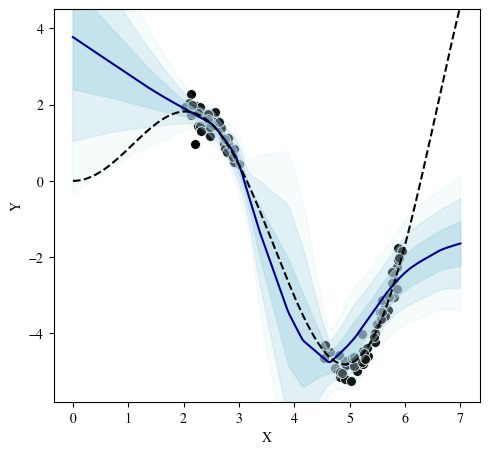

In [18]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import os

from hydra import initialize, compose
from omegaconf import OmegaConf

from train.train import train


from models.mlp import initialise_mlp_models  # Ensure this is correctly imported

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
# Initialize Hydra and compose the configuration
#initialize(version_base="1.3.2", config_path="conf", job_name="test_app")
cfg = compose(config_name="config")
#print(OmegaConf.to_yaml(cfg))
cfg.experiment.batch_size=8
cfg.experiment.lr=5e-2
cfg.experiment.num_epochs=200
cfg.task.dataset='mnist'
cfg.experiment.wandb_logging=False
cfg.experiment.method='SVGD'

# Generate data using the previously defined function
data = generate_1d_dataset(show_plots=False, task_set=4, data_random_seed=42)
train_x, train_y = data.train_x, data.train_y
test_x, test_y = data.test_x, data.test_y

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# Reshape the data to 2D arrays
x_train = x_train.reshape(-1, 1)
x_val = x_val.reshape(-1, 1)
test_x = test_x.reshape(-1, 1)
y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)
test_y = test_y.reshape(-1,1)

# Normalize the data
#scaler = StandardScaler()
#x_train = scaler.fit_transform(x_train)
#x_val = scaler.transform(x_val)
#test_x = scaler.transform(test_x)

print('x_train', x_train.shape)
print('x_val', x_val.shape)
print('test_x', test_x.shape)

# Create datasets
train_dataset = CustomDataset(x_train, y_train)
val_dataset = CustomDataset(x_val, y_val)
test_dataset = CustomDataset(test_x, test_y)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize MLP models
input_dim = x_train.shape[1]
output_dim = 1  # Assuming the target variable is a single dimension
num_models = cfg.experiment.n_particles  # Number of models in the ensemble




modellist = initialise_mlp_models(input_dim, output_dim, cfg)

# Train the models
#loss = train(modellist, cfg['experiment']['lr'], cfg['experiment']['num_epochs'], train_dataloader, val_dataloader, device, cfg)
# Train the models while suppressing print statements
with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    loss = train(modellist, cfg['experiment']['lr'], cfg['experiment']['num_epochs'], train_dataloader, val_dataloader, device, cfg)


# Function to generate predictions
def predict(models, dataloader, device):
    models = [model.to(device) for model in models]
    for model in models:
        model.eval()
    mean_predictions = []
    std_predictions = []
    with torch.no_grad():
        for x_batch, _ in dataloader:
            x_batch = x_batch.to(device)
            batch_preds = [model(x_batch).cpu().numpy() for model in models]
            batch_preds = np.stack(batch_preds, axis=0)
            batch_mean = np.mean(batch_preds, axis=0)
            batch_std = np.std(batch_preds, axis=0)
            mean_predictions.extend(batch_mean)
            std_predictions.extend(batch_std)
    return np.array(mean_predictions), np.array(std_predictions)

# Generate predictions on the test set
mean_predictions, std_predictions = predict(modellist, test_dataloader, device)

# Flatten arrays for plotting
train_x = train_x.flatten()
train_y = train_y.flatten()
test_x = test_x.flatten()
test_y = test_y.flatten()
mean_predictions = mean_predictions.flatten()
std_predictions = std_predictions.flatten()

sorted_indices = np.argsort(test_x)
test_x_sorted = test_x[sorted_indices]
mean_predictions_sorted = mean_predictions[sorted_indices]
std_predictions_sorted = std_predictions[sorted_indices]


# Plotting the results
plt.figure(figsize=figsizes.neurips2024(nrows=3)["figure.figsize"])
print(figsizes.neurips2024(nrows=3)["figure.figsize"])
# Plot the training data in black
sns.scatterplot(x=train_x, y=train_y, color='black', s=50)

# Plot the test data in red
#sns.scatterplot(x=test_x_sorted, y=test_y[sorted_indices], color='red', label='Test Data', s=50)

# Plot the predicted mean in green
sns.lineplot(x=test_x_sorted, y=mean_predictions_sorted, color='darkblue')

# Plot the true function in a dashed line
plt.plot(data.test_x, data.true_test_y,  linestyle='--', color='black')
    

# Plot the uncertainty bands
plt.fill_between(test_x_sorted, 
                 mean_predictions_sorted - std_predictions_sorted, 
                 mean_predictions_sorted + std_predictions_sorted, 
                 color='lightblue', alpha=0.5, label='±1 Std Dev')
plt.fill_between(test_x_sorted, 
                 mean_predictions_sorted - 2 * std_predictions_sorted, 
                 mean_predictions_sorted + 2 * std_predictions_sorted, 
                 color='lightblue', alpha=0.3, label='±2 Std Dev')
plt.fill_between(test_x_sorted, 
                 mean_predictions_sorted - 3 * std_predictions_sorted, 
                 mean_predictions_sorted + 3 * std_predictions_sorted, 
                 color='lightblue', alpha=0.1, label='±3 Std Dev')

# Set labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.ylim(-5.8, 4.5)
#plt.title(f'Method: {cfg.experiment.method}, Lr: {cfg.experiment.lr}')


#plt.legend()
plt.show()

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from hydra import initialize, compose
from omegaconf import OmegaConf

from train.train import train


from models.mlp import initialise_mlp_models  # Ensure this is correctly imported

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
# Initialize Hydra and compose the configuration
#initialize(version_base="1.3.2", config_path="conf", job_name="test_app")
cfg = compose(config_name="config")
#print(OmegaConf.to_yaml(cfg))
cfg.experiment.batch_size=8
cfg.experiment.lr=1e-2
cfg.experiment.num_epochs=200
cfg.task.dataset='mnist'
cfg.experiment.wandb_logging=False
cfg.experiment.method='SVN'

# Generate data using the previously defined function
data = generate_1d_dataset(show_plots=False, task_set=4, data_random_seed=42)
train_x, train_y = data.train_x, data.train_y
test_x, test_y = data.test_x, data.test_y

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# Reshape the data to 2D arrays
x_train = x_train.reshape(-1, 1)
x_val = x_val.reshape(-1, 1)
test_x = test_x.reshape(-1, 1)
y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)
test_y = test_y.reshape(-1,1)

# Normalize the data
#scaler = StandardScaler()
#x_train = scaler.fit_transform(x_train)
#x_val = scaler.transform(x_val)
#test_x = scaler.transform(test_x)

print('x_train', x_train.shape)
print('x_val', x_val.shape)
print('test_x', test_x.shape)

# Create datasets
train_dataset = CustomDataset(x_train, y_train)
val_dataset = CustomDataset(x_val, y_val)
test_dataset = CustomDataset(test_x, test_y)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize MLP models
input_dim = x_train.shape[1]
output_dim = 1  # Assuming the target variable is a single dimension
num_models = cfg.experiment.n_particles  # Number of models in the ensemble




modellist = initialise_mlp_models(input_dim, output_dim, cfg)


# Train the models
#loss = train(modellist, cfg['experiment']['lr'], cfg['experiment']['num_epochs'], train_dataloader, val_dataloader, device, cfg)

# Train the models while suppressing print statements
with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    loss = train(modellist, cfg['experiment']['lr'], cfg['experiment']['num_epochs'], train_dataloader, val_dataloader, device, cfg)


# Function to generate predictions
def predict(models, dataloader, device):
    models = [model.to(device) for model in models]
    for model in models:
        model.eval()
    mean_predictions = []
    std_predictions = []
    with torch.no_grad():
        for x_batch, _ in dataloader:
            x_batch = x_batch.to(device)
            batch_preds = [model(x_batch).cpu().numpy() for model in models]
            batch_preds = np.stack(batch_preds, axis=0)
            batch_mean = np.mean(batch_preds, axis=0)
            batch_std = np.std(batch_preds, axis=0)
            mean_predictions.extend(batch_mean)
            std_predictions.extend(batch_std)
    return np.array(mean_predictions), np.array(std_predictions)

# Generate predictions on the test set
mean_predictions, std_predictions = predict(modellist, test_dataloader, device)

# Flatten arrays for plotting
train_x = train_x.flatten()
train_y = train_y.flatten()
test_x = test_x.flatten()
test_y = test_y.flatten()
mean_predictions = mean_predictions.flatten()
std_predictions = std_predictions.flatten()

sorted_indices = np.argsort(test_x)
test_x_sorted = test_x[sorted_indices]
mean_predictions_sorted = mean_predictions[sorted_indices]
std_predictions_sorted = std_predictions[sorted_indices]


# Plotting the results
#plt.figure(figsize=(12, 6))
plt.figure(figsize=figsizes.neurips2024(nrows=3)["figure.figsize"])
print(figsizes.neurips2024(nrows=3)["figure.figsize"])


# Plot the training data in black
sns.scatterplot(x=train_x, y=train_y, color='black',  s=50)

# Plot the test data in red
#sns.scatterplot(x=test_x_sorted, y=test_y[sorted_indices], color='red', label='Test Data', s=50)

# Plot the predicted mean in green
sns.lineplot(x=test_x_sorted, y=mean_predictions_sorted, color='darkblue')

# Plot the true function in a dashed line
plt.plot(data.test_x, data.true_test_y,  linestyle='--', color='black')
#plt.figure(figsize=figsizes.neurips2024(nrows=3)["figure.figsize"])


# Plot the uncertainty bands
plt.fill_between(test_x_sorted, 
                 mean_predictions_sorted - std_predictions_sorted, 
                 mean_predictions_sorted + std_predictions_sorted, 
                 color='lightblue', alpha=0.5, label='±1 Std Dev')
plt.fill_between(test_x_sorted, 
                 mean_predictions_sorted - 2 * std_predictions_sorted, 
                 mean_predictions_sorted + 2 * std_predictions_sorted, 
                 color='lightblue', alpha=0.3, label='±2 Std Dev')
plt.fill_between(test_x_sorted, 
                 mean_predictions_sorted - 3 * std_predictions_sorted, 
                 mean_predictions_sorted + 3 * std_predictions_sorted, 
                 color='lightblue', alpha=0.1, label='±3 Std Dev')

# Set labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.ylim(-5.8, 4.5)
#plt.title(f'Method: {cfg.experiment.method}, Lr: {cfg.experiment.lr}')


#plt.legend()
plt.show()

NameError: name 'generate_1d_dataset' is not defined